In [3]:
scatter_style <- function(ggplot_,legend_position='none',xlab_='PC1',ylab_='PC2',title='',
                          x.angle=0,ratio=1){
    sp <- ggplot_+theme_classic()+  
        #border()+
#         xlab(xlab_)+
#         ylab(ylab_)+
        ggtitle(title)+
        theme(legend.position=legend_position,
              title=element_text(size = 8, face = "bold"),
              aspect.ratio = ratio, 
                axis.text.x = element_text(angle=x.angle,size = 8),
                axis.title.x = element_text(size = 8, face = "bold"),
                axis.text.y = element_text(size = 8),
                axis.title.y = element_text(size = 8, face = "bold"))
    return(sp)
}

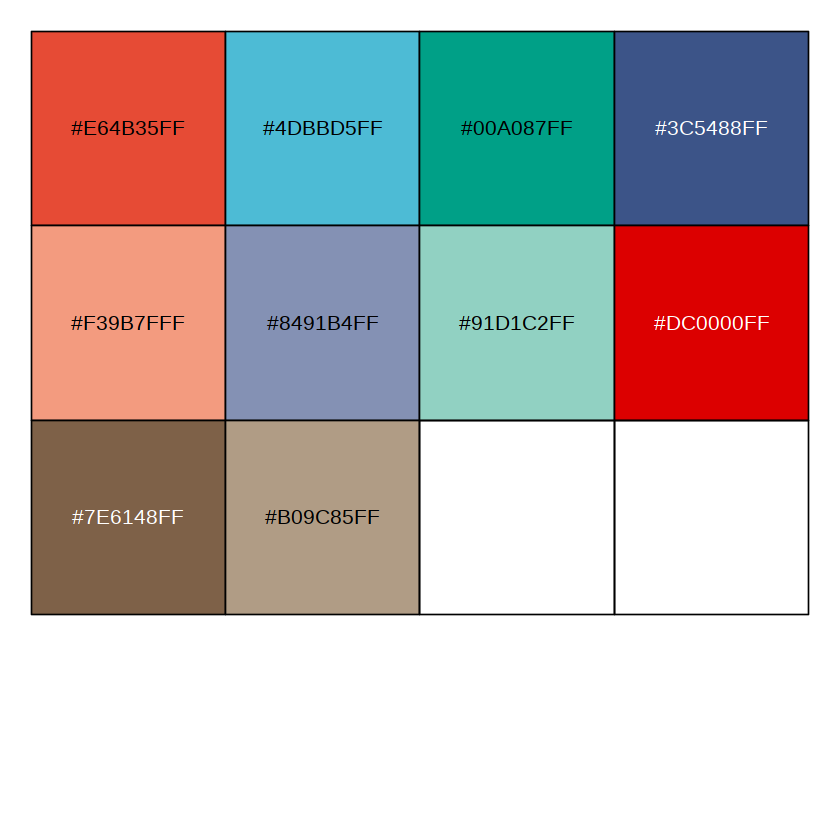

In [4]:
colors_ <- ggsci::pal_npg()(10)
scales::show_col(ggsci::pal_npg()(10))

In [5]:
color_ <- colors_[c(1,2)]

## load variables

In [6]:
source('../../function.r')

In [7]:
psize(6,6)

In [8]:
load('variables_fromPreprocessing.image')

In [9]:
ls()

[1] "color_"                 "colors_"                "CROP_variable_genes"   
 [4] "get_beta_EM_sep_method" "psize"                  "restorePsize"          
 [7] "scatter_style"          "X_design.stimulated"    "Y.stimulated"          
[10] "Z.stimulated"

In [10]:
CROP_variable_genes[grep('CD69',CROP_variable_genes)]

[1] "CD69"

In [11]:
# gene names mentioned in paper
a <- read.csv(file='./165genes.txt',header = F,row.names=1)
paper_mentioned_gene_names <- gsub(" ","", rownames(a))

## Normalize the data -- make each cell's library size EQUAL

In [12]:
Y.stimulated <- (Y.stimulated/rowSums(Y.stimulated)*10000)
Z.stimulated <- (Z.stimulated/rowSums(Z.stimulated)*10000)

# preprocessing of control cells Z

### counts to log(counts)  and select variable genes

In [13]:
Z_log <- log(Z.stimulated+1)
colnames(Z_log) <- gsub("_","-", colnames(Z_log))
Z_log_sub <- Z_log[,CROP_variable_genes]

In [14]:
Z.stimulated%>%rowSums()%>%head

TACTTGACCCCN ATCTAGATACNN GCATCAGTAATN GTCTAATGTCNN CTCGAGACTTGG TACTAACGACAA 
       10000        10000        10000        10000        10000        10000

### do PCA without center or scaling on Variable Genes

In [120]:
Z_log_sub%>%dim

[1] 705 600

In [122]:
Z_pca_results <- prcomp(Z_log_sub, center=TRUE, scale. = FALSE)


In [123]:
pc.select.sdev <- which(Z_pca_results$sdev >1)

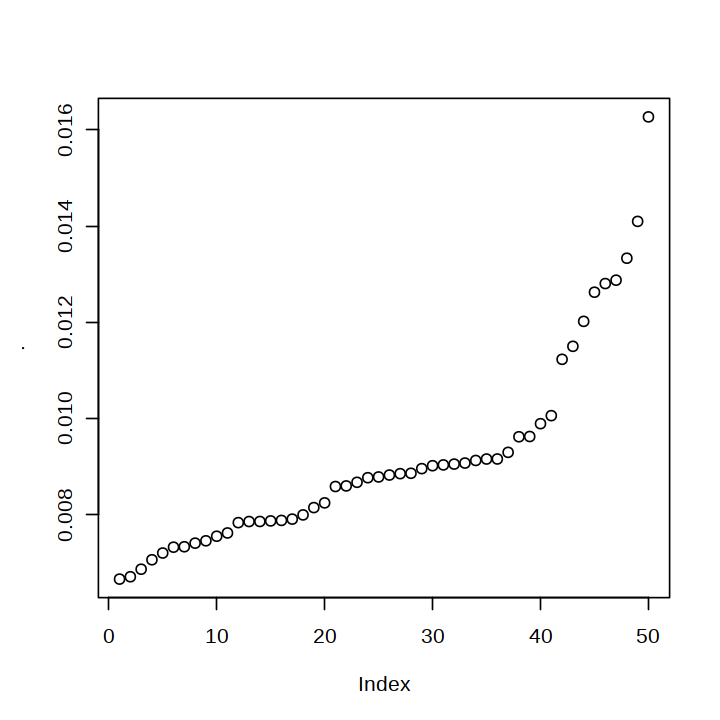

In [124]:
(Z_pca_results$x)[,1:50]%>%apply(2,function(x){x%>%dip.test%>%.[['statistic']]})%>%sort%>%plot

In [125]:
select.pcs <- which((Z_pca_results$x)[,pc.select.sdev]%>%apply(2,function(x){x%>%dip.test%>%.[['statistic']]})>0.012)

In [126]:
(Z_pca_results$x)[,pc.select.sdev]%>%apply(2,function(x){x%>%dip.test%>%.[['statistic']]})

PC1         PC2         PC3         PC4         PC5         PC6 
0.012873610 0.008955327 0.008766612 0.007060523 0.009617959 0.007905691 
        PC7         PC8         PC9        PC10        PC11        PC12 
0.009889988 0.014095735 0.006864336 0.007855638 0.006707611 0.007856769 
       PC13        PC14        PC15        PC16        PC17        PC18 
0.012017356 0.010056755 0.008583702 0.007331215 0.016268554 0.006658529 
       PC19        PC20 
0.007550024 0.008822157

In [127]:
select.pcs <- select.pcs[c(1,2,4)]

In [128]:
select.pcs

PC1  PC8 PC17 
   1    8   17

# select cell*PCs matrix

### get PCA  matrix and rotation

In [129]:
Z_PC_matrix <- Z_pca_results$x

Z_projection_genebypc <- Z_pca_results$rotation

In [130]:
#saveRDS(Z_PC_matrix,'../../summary/data/CRISPR_CROP_Z_PC_matrix.rds')

# clculate clusters' parameters on Z (k=2)

In [131]:
set.seed(0)

In [132]:
Z_EM_results <- mvnormalmixEM(Z_PC_matrix[,select.pcs],k = 2)

number of iterations= 163 


In [133]:
z.labels <- Z_EM_results$posterior%>%apply(1,which.max)

In [134]:
psize(6,6)

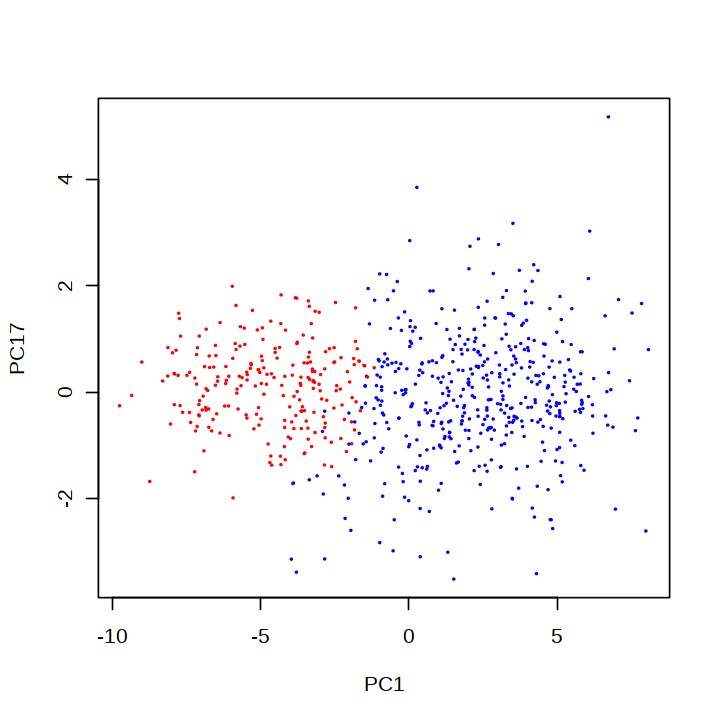

In [135]:
plot(Z_pca_results$x[,c(1,17)],cex=0.1,col = c('red','blue','green','black')[z.labels])

In [54]:
psize(4,4)

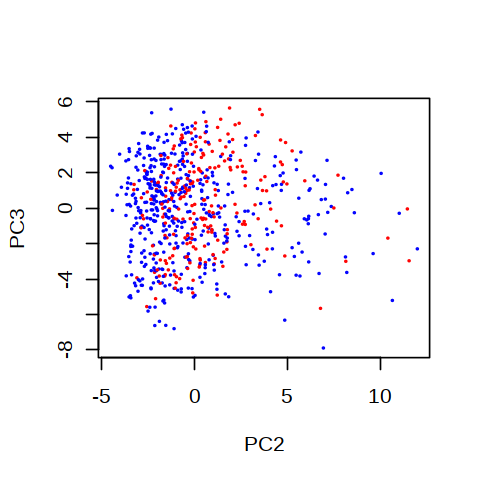

In [55]:
plot(Z_pca_results$x[,c(2,3)],cex=0.1,col = c('red','blue','green','black')[z.labels])

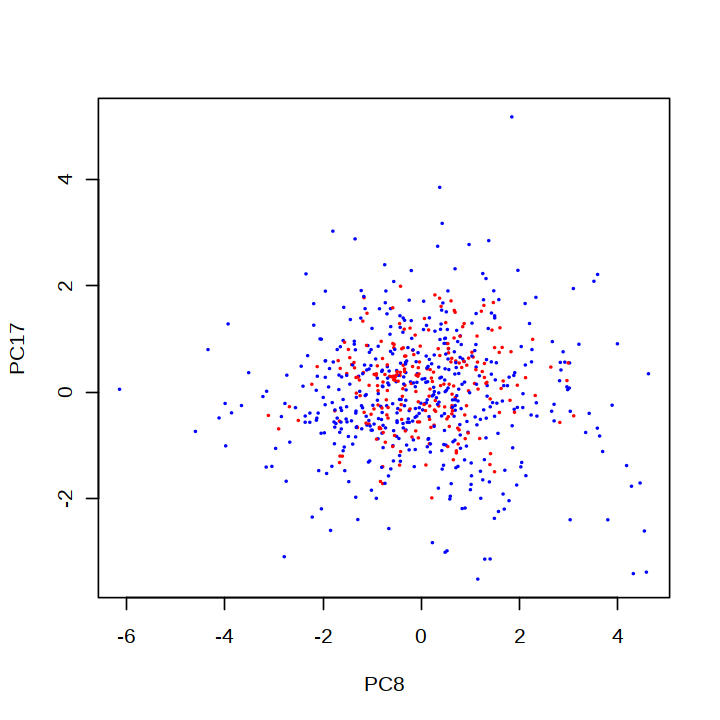

In [32]:
plot(Z_pca_results$x[,c(8,17)],cex=0.1,col = c('red','blue','green','black')[z.labels])

## plots

In [33]:
data.df <- Z_pca_results$x[,select.pcs]%>%as.data.frame

In [34]:
data.df <- data.df%>%mutate(label=as.character(z.labels))

In [35]:
psize(2,2)

In [36]:
plot.pc <- (ggplot(data.df,aes(x=PC1,y=PC17,color=label))+
    geom_point(size = 0.2)+
     scale_color_manual(values = color_)+
    theme_classic())%>%scatter_style()

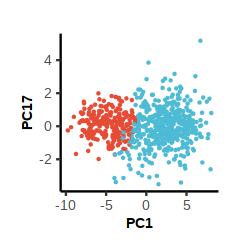

In [37]:
plot.pc

In [38]:
pc.th = 40

In [39]:
a=Z_pca_results$sdev[1:pc.th]/sum(Z_pca_results$sdev)
b=(Z_pca_results$x)[,1:pc.th]%>%apply(2,function(x){x%>%dip.test%>%.[['statistic']]})

data.df <- cbind(a,b,0)%>%as.data.frame%>%rename_with(~c('Var','Dip','Label'))

data.df[select.pcs,'Label'] <- 1

In [40]:
data.df <- data.df%>%rownames_to_column('id')%>%pivot_longer(cols = Var:Dip)%>%mutate(id=gsub('PC','',id))

In [41]:
data.df$id <- factor(data.df$id, levels=c(1:pc.th))

In [42]:
data.df$value <- data.df$value * 100

In [43]:
psize(4,4)

In [44]:
plot.percentage <- (ggplot(data.df,aes(x=id,y=value,group=name,color=name))+geom_point(size=0.5)+
        geom_line() +
        scale_color_manual(values = colors_[c(8,4)])+
        geom_abline(slope = 0,intercept = 0.0122*100,color=colors_[8],linetype=3)+
        geom_vline(xintercept = 30,color=colors_[4],linetype=3)+
        scale_y_continuous(
            "Explained Variance (%)", 
            sec.axis = sec_axis(~ . , name = "Modality Score (*0.01)")
          )+
        theme_classic()+
        xlab('PCs'))%>%scatter_style()+
        theme(axis.text.x=element_blank(),
              #axis.line.y.right = element_line(color =  colors_[8]),
              axis.ticks.y.right = element_line(color =  colors_[8]),
            axis.text.y.right = element_text(color =  colors_[8]), 
            axis.title.y.right = element_text(color =  colors_[8]),
              
            # axis.line.y.left = element_line(color = colors_[4]),
              axis.ticks.y.left = element_line(color = colors_[4]),
            axis.text.y.left = element_text(color = colors_[4]), 
            axis.title.y.left = element_text(color =colors_[4])
        )

# log and projection

In [45]:
colnames(Y.stimulated) <- gsub('_','-', colnames(Y.stimulated))

Y_sgRNA.stimulated <- list()
Y_sgRNA_cellbypc.stimulated <- list()
for(k in 1:dim(X_design.stimulated)[2]){
    
    Y_sgRNA.stimulated[[k]] <- Y.stimulated[X_design.stimulated[k]==1,CROP_variable_genes]
    #cat("\ndimension of sgRNA",k,": ", dim(Y_sgRNA.stimulated[[k]]))
    
    #Y_sgRNA[[k]] <- apply(Y_sgRNA[[k]],c(1,2),as.double)
    Y_sgRNA_cellbypc.stimulated[[k]] <- log(Y_sgRNA.stimulated[[k]]+1)  %*% Z_projection_genebypc

}

# (STIMULATE) claculate perturbation effects of 600 variable genes

# <font color=red>original paper's results</font>

In [46]:
b <- list()
b_all <- c()
for(k in 1:dim(X_design.stimulated)[2]){
    b[[k]] <- (colMeans(log(Y_sgRNA.stimulated[[k]]+1)) - colMeans(Z_log_sub))
    b_all <- cbind(b_all,b[[k]])
}



In [47]:
Y_sgRNA_all.stimulated <- list()
for(k in 1:dim(X_design.stimulated)[2]){
    
    Y_sgRNA_all.stimulated[[k]] <- Y.stimulated[X_design.stimulated[k]==1,]
    #cat("\ndimension of sgRNA",k," ", colnames(X_design.stimulated)[k],": ", dim(Y_sgRNA_all.stimulated[[k]]))
    
    #Y_sgRNA_all.unstimulated[[k]] <- apply(Y_sgRNA_all[[k]],c(1,2),as.double)
}

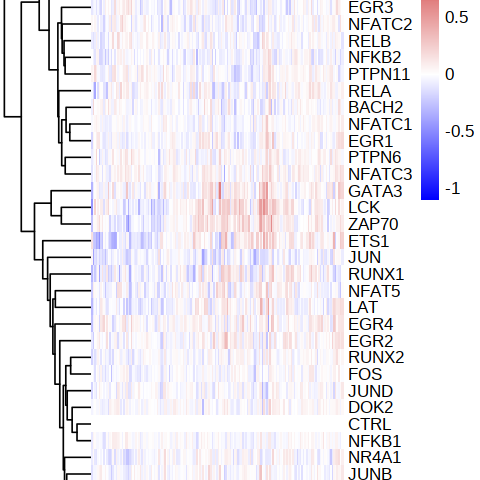

In [48]:
bb.stimulate <- list()
bb_all.stimulated <- c()
for(k in 1:dim(X_design.stimulated)[2]){
    bb.stimulate[[k]] <- (colMeans(log(Y_sgRNA_all.stimulated[[k]]+1)) - colMeans(Z_log))
    bb_all.stimulated <- cbind(bb_all.stimulated,bb.stimulate[[k]])
}


rownames(bb_all.stimulated) <- colnames(Z.stimulated)
colnames(bb_all.stimulated) <- colnames(X_design.stimulated)

max = max(abs(bb_all.stimulated))
len = length(seq(-max,max,0.001))
temp_heatmap <- pheatmap(-t(bb_all.stimulated[intersect(paper_mentioned_gene_names, rownames(bb_all.stimulated)),]),
                         cluster_cols=T,cluster_rows = T,breaks = seq(-max,max,0.001),cellheight=10,
                         #filename="coef_sparse_paper_Tm.pdf",
                         show_colnames = T,show_rownames=T,width=50,fontsize_row=10, fontsize_col=10,angle_col=90,
                         color = colorRampPalette(c("blue", "white", "firebrick3"))(len))

In [49]:
# gene_cluster <- cutree(temp_heatmap$tree_col, k = 2)

# gene_cluster%>%saveRDS('geneCluster_165gene_k2.rds')

# <font color=red>our results</font>

## the perturbation of top 10 PCs

### Mean Methods

In [50]:
beta_PCs_EM_sep_all.stimulated <- list()
beta_PCs_mean_all.stimulated <- list()
Y_PCs_EM_sep_results_all.stimulated <- list()
for(k in 1:dim(X_design.stimulated)[2])
{
    beta_PCs_mean_method.stimulated <- colMeans(Y_sgRNA_cellbypc.stimulated[[k]]) - colMeans(Z_PC_matrix)
    beta_PCs_mean_all.stimulated[[k]] <- beta_PCs_mean_method.stimulated
    # when there are few perturbed cells, using mean results instead.  
    if (colSums(X_design.stimulated)[k]<50){
        beta_PCs_EM_sep_all.stimulated[[k]] <- beta_PCs_mean_method.stimulated[select.pcs]
        next
    }
    Y_PCs_EM_sep_results.stimulated <- get_beta_EM_sep_method(y = Y_sgRNA_cellbypc.stimulated[[k]][,select.pcs],number.component = 2,
                                                      em = Z_EM_results$mu, es = Z_EM_results$sigma, el = Z_EM_results$lambda, 
                                                      beta_init = beta_PCs_mean_method.stimulated[select.pcs] )
    beta_PCs_EM_sep.stimulated <- Y_PCs_EM_sep_results.stimulated$beta
    beta_PCs_EM_sep_all.stimulated[[k]] <- beta_PCs_EM_sep.stimulated

    Y_PCs_EM_sep_results_all.stimulated[[k]] <- Y_PCs_EM_sep_results.stimulated
    
    cat("\n", colnames(X_design.stimulated)[k])
    cat("\ncurrent ratio: ",Y_PCs_EM_sep_results.stimulated$el)
    cat("\noriginal ratio: ", Z_EM_results$lambda)
    
    
}


 CTRL
current ratio:  0.3332614 0.6667386
original ratio:  0.3332628 0.6667372
 JUND
current ratio:  0.6955578 0.3044422
original ratio:  0.3332628 0.6667372
 BACH2
current ratio:  0.1427719 0.8572281
original ratio:  0.3332628 0.6667372
 NFKB2
current ratio:  0.2731705 0.7268295
original ratio:  0.3332628 0.6667372
 JUN
current ratio:  0.3578614 0.6421386
original ratio:  0.3332628 0.6667372
 NFKB1
current ratio:  0.2289761 0.7710239
original ratio:  0.3332628 0.6667372
 JUNB
current ratio:  0.3032998 0.6967002
original ratio:  0.3332628 0.6667372
 NFATC1
current ratio:  0.8441079 0.1558921
original ratio:  0.3332628 0.6667372
 RELA
current ratio:  0.6586547 0.3413453
original ratio:  0.3332628 0.6667372
 RUNX2
current ratio:  0.6283497 0.3716503
original ratio:  0.3332628 0.6667372
 FOS
current ratio:  0.230231 0.769769
original ratio:  0.3332628 0.6667372
 RELB
current ratio:  0.7195506 0.2804494
original ratio:  0.3332628 0.6667372
 ZAP70
current ratio:  0.7469923 0.2530077
origin

In [51]:
psize(2,2)
plot.pc.y.list <- c()
for(i in 1:33 ){
    if(length(Y_PCs_EM_sep_results_all.stimulated[[i]])){
        y.labels <- Y_PCs_EM_sep_results_all.stimulated[[i]]%>%.$ey%>%apply(1,which.max)

        data.df <- Y_sgRNA_cellbypc.stimulated[[i]]%>%.[,select.pcs]%>%as.data.frame%>%
                    mutate(label=as.character(Y_PCs_EM_sep_results_all.stimulated[[i]]%>%.$ey%>%apply(1,which.max)))

        plot.pc.y.list[[i]] <- (ggplot(data.df,aes(x=PC1,y=PC17,color=label))+
            geom_point(size = 0.2)+
            #xlim(-17,5)+
             scale_color_manual(values = color_)+
            theme_classic())%>%scatter_style(
            title = paste( i,Y_PCs_EM_sep_results_all.stimulated[[i]]%>%.$el%>%.[1]%>%round(2))
            )
    }

}

## Get final perturbation effects

## Mean Methods

In [56]:
beta_EM_sep_all.stimulated <- list()
beta_mean_all.stimulated  <- list()
beta_mean_matrix.stimulated  <- c()
beta_EM_matrix.stimulated  <- c()
for(k in 1:dim(X_design.stimulated )[2])
{

    beta_mean_all.stimulated[[k]] <- beta_PCs_mean_all.stimulated[[k]] %*% t(Z_projection_genebypc) - colMeans(Z_log_sub)
    beta_mean_matrix.stimulated <- rbind(beta_mean_matrix.stimulated, beta_mean_all.stimulated[[k]] )

#     beta_EM_sep_all <- beta_PCs_EM_sep_all[[k]] %*% t(Z_projection_genebypc) - colMeans(Z_log_sub)
#     beta_EM_matrix <- cbind(beta_EM_matrix, beta_EM_sep_all[[k]])

    
}
rownames(beta_mean_matrix.stimulated) <- colnames(X_design.stimulated)

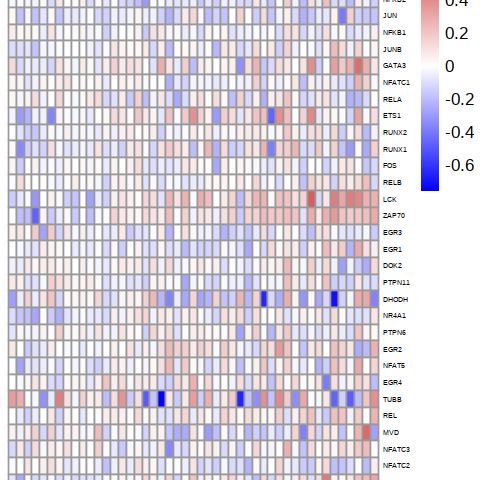

In [57]:
rows<-c('PERK','ATF6','IRE1')
max = max(abs(beta_mean_matrix.stimulated))
len = length(seq(-max,max,0.001))
temp_heatmap <- pheatmap(-(beta_mean_matrix.stimulated)[,intersect(gsub('-','_',gsub(' ','',paper_mentioned_gene_names)), CROP_variable_genes)],
                         cluster_cols=F,cluster_rows = F,breaks = seq(-max,max,0.001),cellheight=10,
                         #filename="coef_sparse_paper_Tm.pdf",
                         show_colnames = T,show_rownames=T,width=20,fontsize_row=4, fontsize_col=4,angle_col=90,
                         color = colorRampPalette(c("blue", "white", "firebrick3"))(len))

## EM results

In [58]:
beta_EM_sep_all.stimulated <- list()
# beta_mean_all <- list()
# beta_mean_matrix <- c()
beta_EM_matrix.stimulated <- c()
for(k in 1:dim(X_design.stimulated)[2])
{

#     beta_mean_all[[k]] <- beta_PCs_mean_all[[k]] %*% t(Z_projection_genebypc) - colMeans(Z_log_sub)
#     beta_mean_matrix <- rbind(beta_mean_matrix, beta_mean_all[[k]] )
    
    beta_EM_sep_tmp <- beta_PCs_mean_all.stimulated[[k]]
    beta_EM_sep_tmp[select.pcs] <-  beta_PCs_EM_sep_all.stimulated[[k]]
    
    beta_EM_sep_all.stimulated[[k]] <- beta_EM_sep_tmp %*% t(Z_projection_genebypc) - colMeans(Z_log_sub)
    beta_EM_matrix.stimulated <- rbind(beta_EM_matrix.stimulated, beta_EM_sep_all.stimulated[[k]])

    
}
rownames(beta_EM_matrix.stimulated) <- colnames(X_design.stimulated)

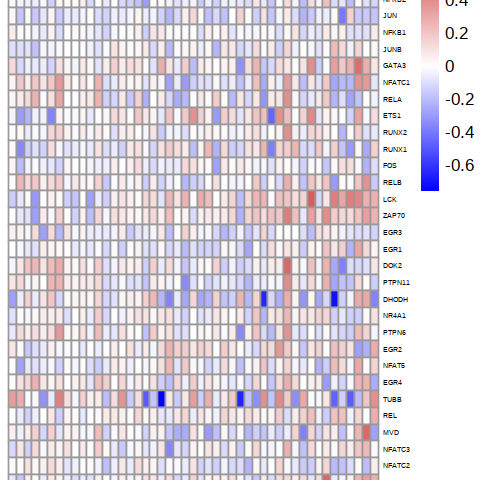

In [59]:
rows<-c('PERK','ATF6','IRE1')
#max = max(abs(beta_EM_matrix.stimulated))
len = length(seq(-max,max,0.001))
temp_heatmap <- pheatmap(-(beta_EM_matrix.stimulated[,intersect(gsub('-','_',gsub(' ','',paper_mentioned_gene_names)), CROP_variable_genes)]),
                         cluster_cols=F,cluster_rows = F,breaks = seq(-max,max,0.001),cellheight=10,
                         #filename="coef_sparse_paper_Tm.pdf",
                         show_colnames = T,show_rownames=T,width=20,fontsize_row=4, fontsize_col=4,angle_col=90,
                         color = colorRampPalette(c("blue", "white", "firebrick3"))(len))

# ALL sgRNAs

In [60]:
beta_EM_matrix_all.stimulated <- cbind(beta_EM_matrix.stimulated, 
                                       t(bb_all.stimulated[setdiff(rownames(bb_all.stimulated),gsub('-','_',CROP_variable_genes)),]) )

beta_mean_matrix_all.stimulated <- cbind(beta_mean_matrix.stimulated, 
                                         t(bb_all.stimulated[setdiff(rownames(bb_all.stimulated),gsub('-','_',CROP_variable_genes)),]))


diff <- beta_EM_matrix_all.stimulated - beta_mean_matrix_all.stimulated

In [63]:
# save(beta_EM_matrix_all.stimulated,beta_mean_matrix_all.stimulated,
#      file='beta_results_topDipPC_n3.image')

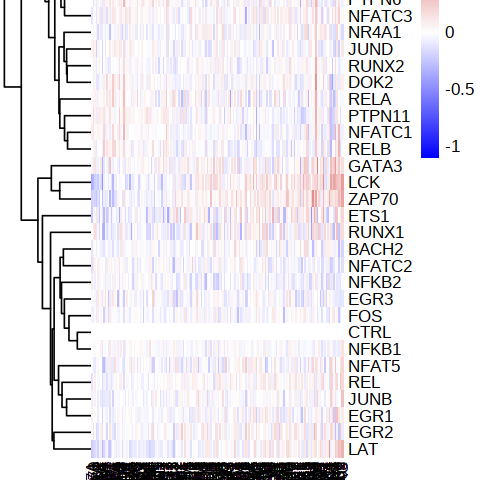

In [64]:

max = max(abs(beta_EM_matrix_all.stimulated))
len = length(seq(-max,max,0.001))
temp_heatmap <- pheatmap(-beta_EM_matrix_all.stimulated[,intersect(paper_mentioned_gene_names, 
                                                                     rownames(bb_all.stimulated))],
                         cluster_cols=F,cluster_rows = T,breaks = seq(-max,max,0.001),cellheight=10,
                         #filename="coef_sparse_paper_Tm.pdf",
                         show_colnames = T,show_rownames=T,width=50,fontsize_row=10, fontsize_col=10,angle_col=90,
                         color = colorRampPalette(c("blue", "white", "firebrick3"))(len))

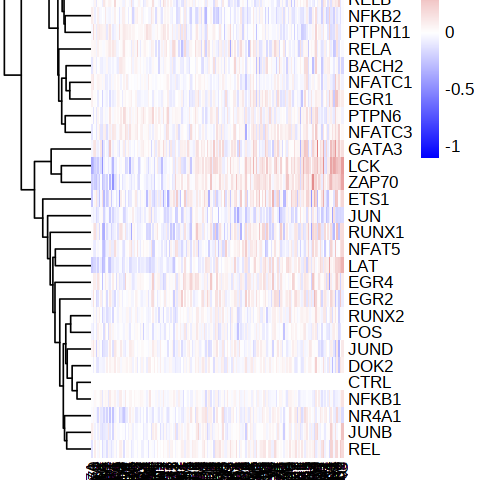

In [65]:

max = max(abs(beta_mean_matrix_all.stimulated))
len = length(seq(-max,max,0.001))
temp_heatmap <- pheatmap(-beta_mean_matrix_all.stimulated[,intersect(paper_mentioned_gene_names, 
                                                                     rownames(bb_all.stimulated))],
                         cluster_cols=F,cluster_rows = T,breaks = seq(-max,max,0.001),cellheight=10,
                         #filename="coef_sparse_paper_T.pdf",
                         show_colnames = T,show_rownames=T,width=50,fontsize_row=10, fontsize_col=10,angle_col=90,
                         color = colorRampPalette(c("blue", "white", "firebrick3"))(len))

In [66]:
em.results <- -beta_EM_matrix_all.stimulated[,intersect(paper_mentioned_gene_names,rownames(bb_all.stimulated))]

In [67]:
mean.results <- -beta_mean_matrix_all.stimulated[,intersect(paper_mentioned_gene_names,rownames(bb_all.stimulated))]

In [68]:
a <- (mean.results[,1:55]%>%rowMeans - (mean.results[,56:ncol(mean.results)]%>%rowMeans))

b <- (em.results[,1:55]%>%rowMeans - (em.results[,56:ncol(mean.results)]%>%rowMeans))

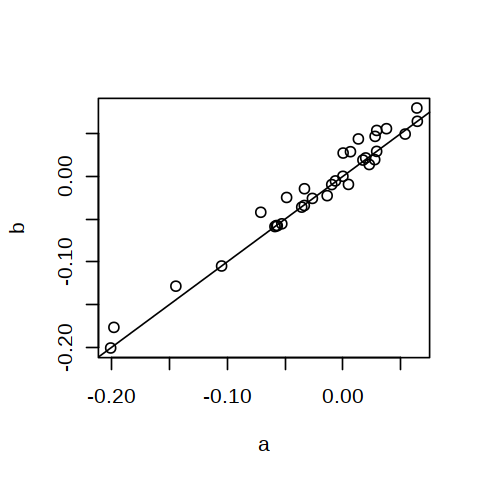

In [69]:
plot(a,b)
abline(a=0,b=1)

In [70]:
re.sc <- cbind(a,b)

In [90]:
bulk.data <- read_csv('data/GSE92872_CROP-seq_Jurkat_TCR.count_matrix.csv.gz')

Rows: 34246 Columns: 88

── Column specification ────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (88): sample_name, Bulk_stimulated_LCK_1, Bulk_stimulated_LCK_2, Bulk_st...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [91]:
a=bulk.data[5:nrow(bulk.data),]%>%as.data.frame%>%column_to_rownames('sample_name')#%>%colSums
aa=a%>%apply(c(1,2),as.numeric)
mat.norm.log <- apply(aa,2,function(x){x/sum(x)*1e4})%>%log1p

In [92]:
bulk.mat <- bulk.data[1:4,]%>%rbind(mat.norm.log%>%as.data.frame%>%rownames_to_column('sample_name'))%>%
            column_to_rownames('sample_name')%>%t%>%as.data.frame%>%
            filter(condition=='stimulated')%>%select(condition:grna,one_of(paper_mentioned_gene_names))%>%
select(!c(condition,grna))

Warning message:
“Unknown columns: `SNORA76C`, `SUV420H1`, `TRBC2`, `MIR4435-1HG`, `HDHD1`, `LINC00152`, `MALAT1`, `TRAC`”


In [93]:
bulk.mat[2:ncol(bulk.mat)] <- bulk.mat[2:ncol(bulk.mat)] %>% apply(c(1,2),as.numeric)

In [94]:
bulk.df <- bulk.mat%>%group_by(gene)%>%summarise_all(mean)

In [95]:
tmp <- bulk.df%>%column_to_rownames('gene')

In [96]:
tmp <- t(tmp)-t(tmp)[,1]

In [99]:
psize(6,6)

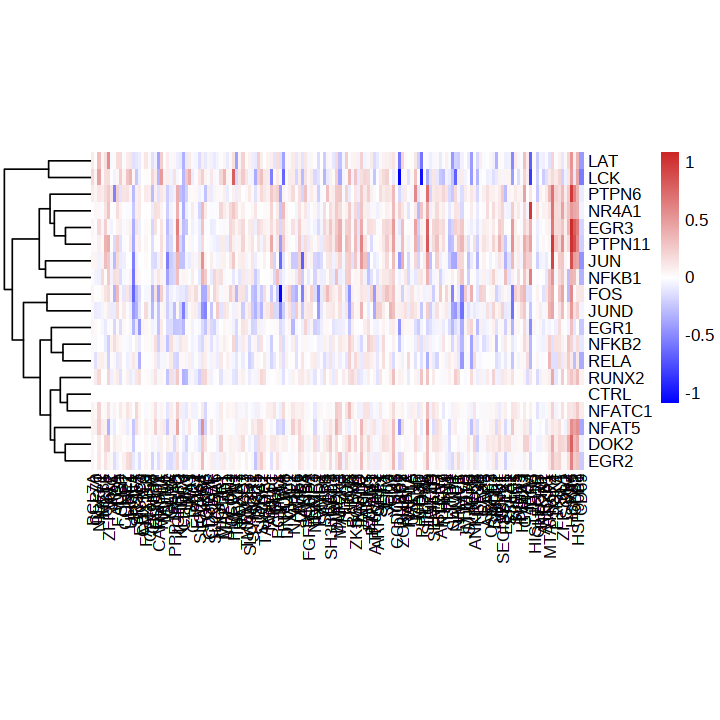

In [100]:

max = max(abs(tmp))
len = length(seq(-max,max,0.001))
temp_heatmap <- pheatmap(t(tmp[intersect(paper_mentioned_gene_names,rownames(tmp)),]),
                         cluster_cols=F,cluster_rows = T,breaks = seq(-max,max,0.001),cellheight=10,
                         #filename="coef_sparse_paper_T.pdf",
                         show_colnames = T,show_rownames=T,width=50,fontsize_row=10, fontsize_col=10,angle_col=90,
                         color = colorRampPalette(c("blue", "white", "firebrick3"))(len))

In [79]:
a <- (mean.results[,1:55]%>%rowMeans - (mean.results[,56:ncol(mean.results)]%>%rowMeans))

b <- (em.results[,1:55]%>%rowMeans - (em.results[,56:ncol(mean.results)]%>%rowMeans))

In [80]:
re.sc <- cbind(a,b)

In [81]:
a = tmp[intersect(paper_mentioned_gene_names[1:55],rownames(tmp)),]%>%colMeans

In [82]:
b = tmp[intersect(paper_mentioned_gene_names[55:length(paper_mentioned_gene_names)],rownames(tmp)),]%>%colMeans

In [83]:
bulk=a-b

In [84]:
re <- re.sc%>%as.data.frame%>%rename_with(~c('mean','em'))%>%rownames_to_column('gene')%>%
left_join(as.data.frame(a-b)%>%rownames_to_column('gene'))%>%rename('bulk'='a - b')

Joining, by = "gene"



In [85]:
cor(re$mean,re$bulk,use = 'complete.obs')

[1] -0.7195455

In [86]:
cor(re$em,re$bulk,use = 'complete.obs')

[1] -0.7465965

In [87]:
library(ggrepel)

In [88]:
psize(2,2)

In [1042]:
plot.cor <-(ggplot(re,aes(x=-bulk,y=em))+geom_point(size=0.5)+
      geom_smooth(method=lm, se=TRUE, linetype="dashed",
                 color="darkred")+
    geom_text_repel(aes(label = gene), size = 1.5,segment.size=0.2)+
    scale_x_continuous(breaks = c(-0.1,0,0.1))+
    xlab('Bulk RNA-seq Activation Score')+ylab('Deconvoluted Activation Score')+
    theme_classic())%>%scatter_style() +
    ggtitle(paste0('Pearson Correlation=',
                   cor(re$em,-re$bulk,use = 'complete.obs')%>%round(2)))+
    annotate('text',x=0.05,y=-0.2,size=2,
             label=paste0('R squared=',
                          lm(bulk~em,re)%>%summary%>%.[['r.squared']]%>%round(3),
                         '\n p-value=',anova(lm(bulk~em,re))$'Pr(>F)'[1]%>%round(4)))

In [1044]:
plot.cor2 <-(ggplot(re,aes(x=-bulk,y=mean))+geom_point(size=0.5)+
      geom_smooth(method=lm, se=TRUE, linetype="dashed",
                 color="darkred")+
    geom_text_repel(aes(label = gene), size = 1.5,segment.size=0.2)+
    scale_x_continuous(breaks = c(-0.1,0,0.1))+
    xlab('Bulk RNA-seq Activation Score')+ylab('Observed Activation Score')+
    theme_classic())%>%scatter_style() +
     ggtitle(paste0('Pearson correlation=',
                    cor(re$mean,-re$bulk,use = 'complete.obs')%>%round(2)))+
    annotate('text',x=0.05,y=-0.2,size=2,
             label=paste0('R squared=',
                          lm(bulk~mean,re)%>%summary%>%.[['r.squared']]%>%round(3),
                         '\n p-value=',anova(lm(bulk~mean,re))$'Pr(>F)'[1]%>%round(4)))

In [1422]:
ratios <- Y_PCs_EM_sep_results_all.stimulated%>%lapply(function(x){x$el[1]})

In [1425]:
data.df=ratios %>%unlist%>%cbind(which(colSums(X_design.stimulated)>50)%>%names)%>%
as.data.frame%>%rename_with(~c('value','site'))

In [1426]:
data.df$value=as.numeric(data.df$value)

In [1427]:
data.df$site = factor(data.df$site,levels=which(colSums(X_design.stimulated)>50)%>%names)

In [1428]:
data.df%>%head

,value,site
,<dbl>,<fct>
1,0.3241104,CTRL
2,0.7406017,JUND
3,0.1643061,BACH2
4,0.4073068,NFKB2
5,0.4032881,JUN
6,0.2707531,NFKB1


In [950]:
plot.ratio <- (ggplot(data.df,aes(x=site,y=value))+geom_col(width = 0.8, fill=colors_[10])+theme_classic()+
    theme(axis.text.x = element_text(angle = 70, vjust = 1, hjust=1))+
     geom_hline(yintercept = data.df[1,1],color='black',,linetype=3)+
     xlab('')+ylab('Cluster1\'s Ratio'))%>%scatter_style(ratio=0.2,x.angle=70)+
    theme(axis.text.x = element_text(angle = 70, vjust = 1, hjust=1))

In [1086]:
em.results[,'CD69']

CTRL          JUND         BACH2         NFKB2           JUN 
 1.727520e-07  1.839772e-02  9.838133e-02 -1.448653e-01 -1.745643e-01 
        NFKB1          JUNB         GATA3        NFATC1          RELA 
 6.829880e-02  2.800789e-02  8.296821e-02 -2.666153e-02 -1.855507e-02 
         ETS1         RUNX2         RUNX1           FOS          RELB 
 1.148878e-01 -4.681682e-02  1.635549e-01 -1.065586e-01 -1.249857e-01 
          LCK         ZAP70          EGR3          EGR1          DOK2 
 2.714553e-01  2.781691e-01 -1.636264e-01  3.909830e-02  1.048737e-01 
       PTPN11         DHODH         NR4A1         PTPN6          EGR2 
-1.177733e-01 -3.644718e-01  1.029904e-01  4.841603e-02  2.969824e-01 
        NFAT5          EGR4          TUBB           REL           MVD 
 1.640061e-01 -2.141914e-01  3.862826e-01  2.511939e-01 -2.761792e-01 
       NFATC3        NFATC2           LAT 
 4.662739e-03  6.086368e-02  2.802837e-01

In [1087]:
mean.results[,'CD69']

CTRL          JUND         BACH2         NFKB2           JUN 
 3.330669e-15  1.244232e-03  5.153624e-02 -1.343477e-01 -1.726433e-01 
        NFKB1          JUNB         GATA3        NFATC1          RELA 
 5.785829e-02  3.326967e-02  8.296821e-02 -2.135811e-02 -5.785935e-04 
         ETS1         RUNX2         RUNX1           FOS          RELB 
 1.148878e-01 -3.784347e-02  1.635549e-01 -1.176476e-01 -1.160247e-01 
          LCK         ZAP70          EGR3          EGR1          DOK2 
 2.714553e-01  2.924707e-01 -1.519962e-01  5.099998e-02  1.325392e-01 
       PTPN11         DHODH         NR4A1         PTPN6          EGR2 
-1.050773e-01 -3.644718e-01  8.375736e-02  2.116720e-02  2.704398e-01 
        NFAT5          EGR4          TUBB           REL           MVD 
 1.495276e-01 -1.945943e-01  3.862826e-01  2.677522e-01 -2.761792e-01 
       NFATC3        NFATC2           LAT 
-3.866993e-03  6.083885e-02  3.043809e-01

In [1090]:
psize(4,4)

In [1118]:
data.df <- cbind(mean.results[,'CD69'],em.results[,'CD69'])%>%
        as.data.frame%>%rename_with(~c('mean','em'))%>%
        rownames_to_column('label')

In [1125]:
data.df <- data.df%>%mutate(diff=mean-em)%>%mutate(label.use=ifelse(abs(diff)>0.01,label,''))


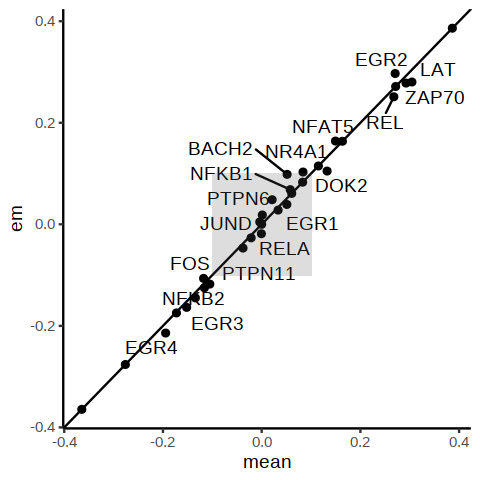

In [1127]:
ggplot(data.df,aes(x=mean,y=em,label=label.use))+geom_point()+
geom_abline(slope = 1,intercept = 0)+
geom_text_repel()+
 annotate("rect", xmin = -0.1, xmax = 0.1, ymin = -0.1, ymax = 0.1,
        alpha = .2)+
theme_classic()

## CD 69 flow cytometry

In [1138]:
mat <- read_csv('data/flow_analysis.csv')%>%filter(is.na(failed),condition=='stimulated')

Rows: 192 Columns: 33

── Column specification ────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr   (5): experiment, condition, gene, grna, fcs_file
dbl  (26): grna_number, well_number, run_, %Live, %CD38+, %CD69+, %PD1+, %pR...
lgl   (1): failed
date  (1): date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [1398]:
data.flow <- mat%>%filter(!is.na(`%CD69+`))%>%group_by(gene)%>%summarise(cd69=mean(`%CD69+`),sd=sd(`%CD69+`))

In [1399]:
data.flow.all <- mat%>%filter(!is.na(`%CD69+`))%>%select(gene,`%CD69+`)%>%rename_with(~c('gene','cd69'))

In [1400]:
data.infer <- cbind(mean.results[,'CD69'],em.results[,'CD69'])%>%
        as.data.frame%>%rename_with(~c('mean','em'))%>%
        rownames_to_column('gene')

In [1401]:
data.df <- data.flow%>%left_join(data.infer,by='gene')%>%arrange(cd69)

In [1402]:
cor(data.df$em,data.df$cd69,method = 'spearman')

[1] -0.3961039

In [1403]:
cor(data.df$mean,data.df$cd69,method = 'spearman')

[1] -0.4168831

In [1404]:
psize(10,2)

In [1405]:
data.df$gene <- factor(data.df$gene,levels=data.df$gene)

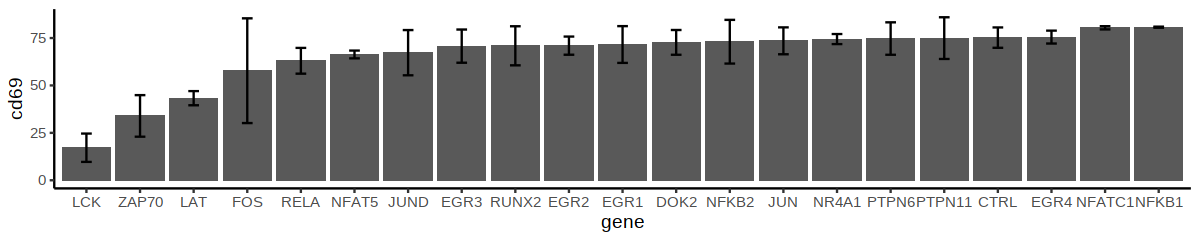

In [1406]:
ggplot(data.df,aes(x=gene,y=cd69))+
geom_bar(stat="identity", position=position_dodge()) +
  geom_errorbar(aes(ymin=cd69-sd, ymax=cd69+sd), width=.2,
                 position=position_dodge(.9))+theme_classic()

In [1407]:
data.df%>%pull(gene)%>%as.character

[1] "LCK"    "ZAP70"  "LAT"    "FOS"    "RELA"   "NFAT5"  "JUND"   "EGR3"  
 [9] "RUNX2"  "EGR2"   "EGR1"   "DOK2"   "NFKB2"  "JUN"    "NR4A1"  "PTPN6" 
[17] "PTPN11" "CTRL"   "EGR4"   "NFATC1" "NFKB1"

In [1408]:
test.less <- lapply(data.df%>%pull(gene)%>%as.character,
      function(x){t.test(data.flow.all%>%filter(gene==x)%>%pull(cd69),
       data.flow.all%>%filter(gene=='CTRL')%>%pull(cd69),
       alternative = 'less')$p.value})%>%unlist

In [1409]:
test.greater <- lapply(data.df%>%pull(gene)%>%as.character,
      function(x){t.test(data.flow.all%>%filter(gene==x)%>%pull(cd69),
       data.flow.all%>%filter(gene=='CTRL')%>%pull(cd69),
       alternative = 'greater')$p.value})%>%unlist

In [1410]:
cbind(data.df,test.less,test.greater)#%>%filter(test.less<0.11|test.greater<0.11)

gene,cd69,sd,mean,em,test.less,test.greater
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LCK,17.15500,7.4761019,2.714553e-01,2.714553e-01,3.779147e-05,0.999962209
ZAP70,33.92500,10.9606493,2.924707e-01,2.781691e-01,1.402748e-03,0.998597252
LAT,43.27500,3.7321799,3.043809e-01,2.802837e-01,5.630424e-07,0.999999437
FOS,57.77500,27.6091018,-1.176476e-01,-1.065586e-01,1.482444e-01,0.851755609
RELA,63.00000,6.7882251,-5.785935e-04,-1.855507e-02,1.023715e-01,0.897628494
NFAT5,66.33333,2.0526406,1.495276e-01,1.640061e-01,1.169162e-03,0.998830838
JUND,67.27500,11.9212346,1.244232e-03,1.839772e-02,1.396087e-01,0.860391294
EGR3,70.72500,8.7488571,-1.519962e-01,-1.636264e-01,1.978692e-01,0.802130793
RUNX2,70.90000,10.3058236,-3.784347e-02,-4.681682e-02,2.747432e-01,0.725256840


In [1412]:
psize(4,2)

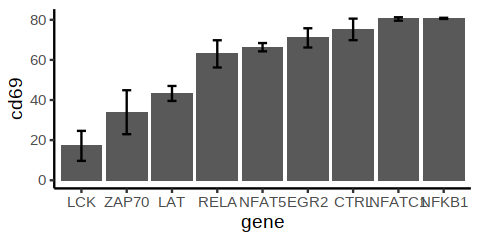

In [1414]:
ggplot(data.df%>%filter(gene=='CTRL' | test.less<0.11|test.greater<0.11),
       aes(x=gene,y=cd69))+
geom_bar(stat="identity", position=position_dodge()) +
  geom_errorbar(aes(ymin=cd69-sd, ymax=cd69+sd), width=.2,
                 position=position_dodge(.9))+theme_classic()

In [1389]:
rank.abs.em <- beta_EM_matrix_all.stimulated%>%abs%>%desc%>%apply(1,rank)%>%.['CD69',]/ncol(beta_EM_matrix_all.stimulated)*100

rank.abs.mean <- beta_mean_matrix_all.stimulated%>%abs%>%desc%>%apply(1,rank)%>%.['CD69',]/ncol(beta_EM_matrix_all.stimulated)*100

In [1390]:
psize(10,10)

In [1391]:
data.df <- cbind(rank.abs.em,rank.abs.mean)%>%as.data.frame%>%
            rownames_to_column('gene')%>%mutate(em.symbol=beta_EM_matrix_all.stimulated[,'CD69']>0,
                                               mean.symbol=beta_mean_matrix_all.stimulated[,'CD69']>0)

In [1392]:
psize(4,2)

In [1395]:
plot.rank <- (data.df%>%ggplot(aes(x=rank.abs.em, y=rank.abs.mean,label=gene))+
        geom_point(size=.5)+theme_classic()+
        geom_text_repel(max.overlaps = 20,size=2)+
        geom_abline(slope = 1,intercept = 0)+
        ylim(0,100)+
        xlim(0,100)+
        xlab('Deconvoluted Response(%)')+
        ylab('Observed Response(%)'))%>%scatter_style(title = 'Absolute Response\'s Rank of CD69')

Warning message:
“ggrepel: 19 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


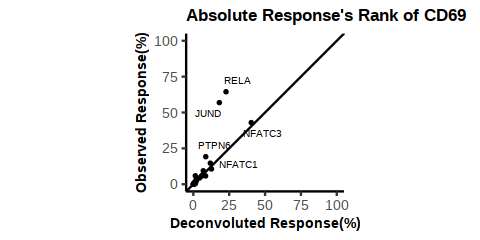

In [1396]:
plot.rank

In [1339]:
rank.abs.em <- beta_EM_matrix_all.stimulated%>%desc%>%apply(1,rank)%>%.['CD69',]

rank.abs.mean <- beta_mean_matrix_all.stimulated%>%desc%>%apply(1,rank)%>%.['CD69',]

psize(10,10)

data.df <- cbind(rank.abs.em,rank.abs.mean)%>%as.data.frame%>%
            rownames_to_column('gene')%>%mutate(em.symbol=beta_EM_matrix_all.stimulated[,'CD69']>0,
                                               mean.symbol=beta_mean_matrix_all.stimulated[,'CD69']>0)

data.df%>%ggplot(aes(x=rank.abs.em, y=rank.abs.mean,label=gene))+
geom_point()+theme_classic()+
geom_text_repel(max.overlaps = 20)+
geom_abline(slope = 1,intercept = 0)+
geom_hline(yintercept = ncol(beta_EM_matrix_all.stimulated)/2)+
geom_vline(xintercept = ncol(beta_EM_matrix_all.stimulated)/2)+
ylim(0,ncol(beta_EM_matrix_all.stimulated))+
xlim(0,ncol(beta_EM_matrix_all.stimulated))

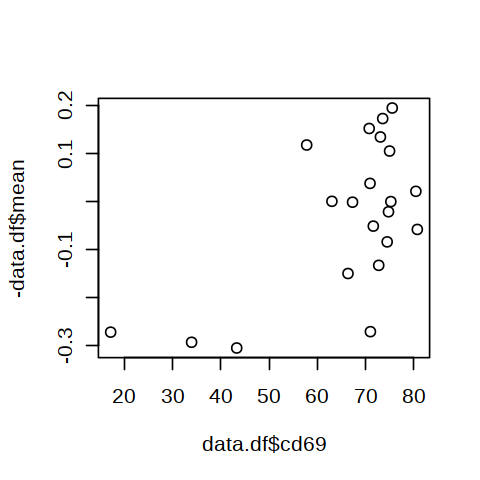

In [1165]:
plot(data.df$cd69,-data.df$mean)

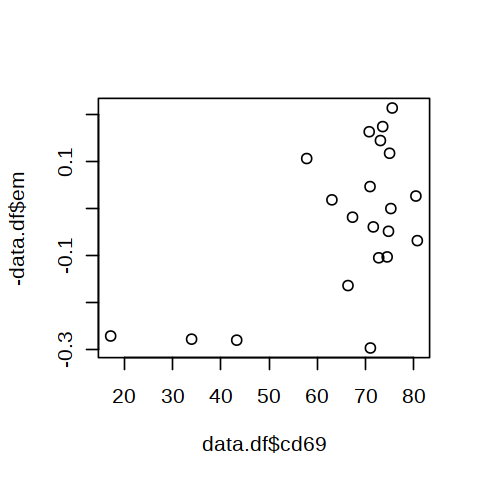

In [1164]:
plot(data.df$cd69,-data.df$em)

In [846]:
library(patchwork)

In [1418]:
psize(12,4.7)

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 14 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 14 rows containing missing values (geom_point).”
Warning message:
“Removed 14 rows containing missing values (geom_text_repel).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 14 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 14 rows containing missing values (geom_point).”
Warning message:
“Removed 14 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 28 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 14 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 14 rows containing missing values (geom_point).”
Warning message:
“Removed 14 rows containing missing values (geom_text_repel).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 14 rows c

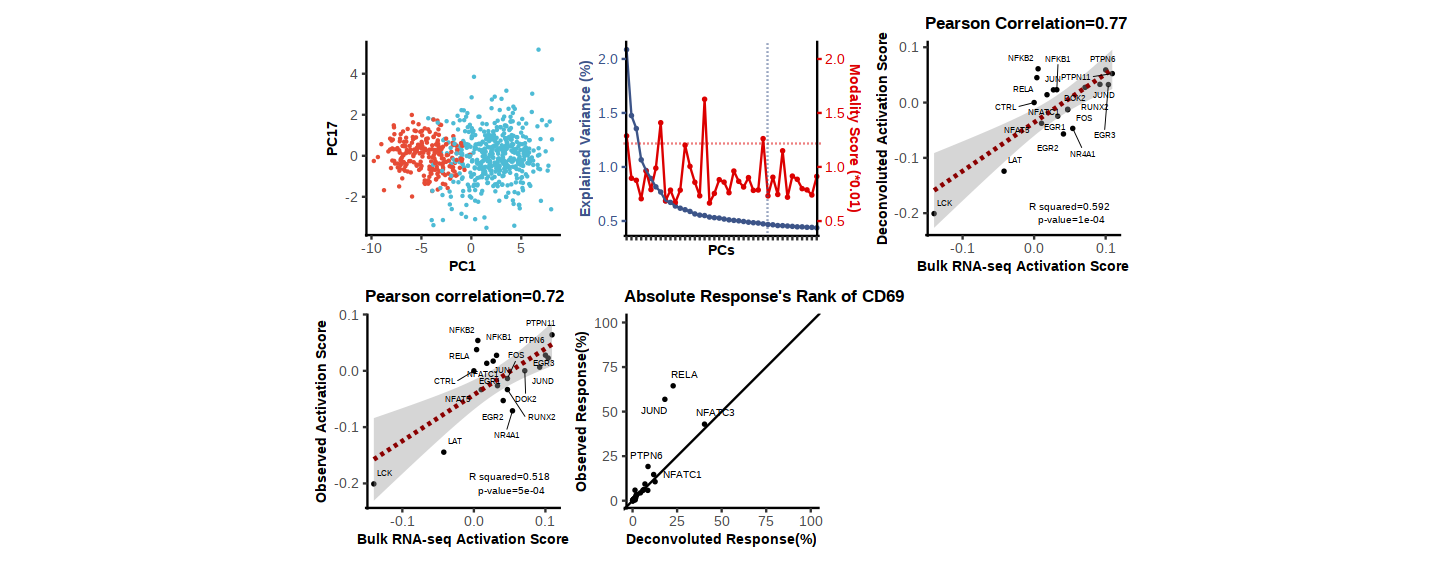

In [1420]:
plot.pc+plot.percentage+plot.cor+plot.cor2+plot.rank#+plot_layout(ncol = 4)
ggsave('results/scatter_line_plots.pdf',width = 12,height = 4.7)

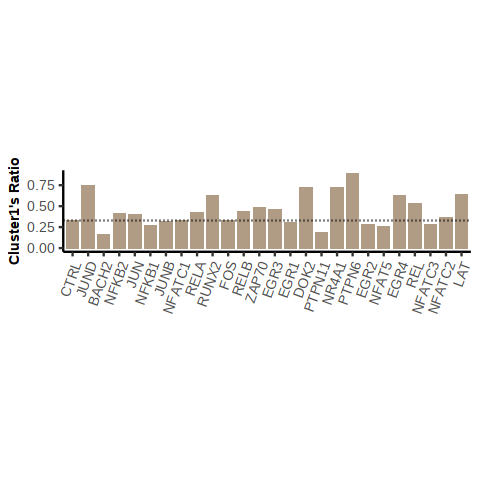

In [996]:
plot.ratio
ggsave('results/bar_plots.pdf',width = 10,height = 2)

In [89]:
save.image('images/CROP-seq_calculation_0330_n3.image')